#Fetching the dataset

In [1]:
!pip install -q kaggle

In [2]:
!mkdir ~/.kaggle

In [3]:
!cp kaggle.json ~/.kaggle/

Giving only read and write permission to owner


In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d laotse/credit-risk-dataset

  0% 0.00/368k [00:00<?, ?B/s]
100% 368k/368k [00:00<00:00, 97.6MB/s]


In [6]:
!unzip /content/credit-risk-dataset.zip

Archive:  /content/credit-risk-dataset.zip
  inflating: credit_risk_dataset.csv  


Importing necessary libraries

In [228]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform, randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import auc,roc_curve, accuracy_score, confusion_matrix, roc_auc_score, classification_report, precision_recall_fscore_support, recall_score
import xgboost as xgb
import os
import warnings
warnings.filterwarnings('ignore')

In [101]:
data = pd.read_csv('/content/credit_risk_dataset.csv')

# Understanding the dataset

In [67]:
data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [68]:
data.shape

(32581, 12)

1.   dataaset contains 32581 observations and 12 characteristics
2.   Out of these 11 are the features (independent variables) and 1 is the dependent variable



In [69]:
data.columns.values

array(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length'],
      dtype=object)

In [70]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB




*   data has float, integer and object values


In [71]:
data.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


**Key Obsevations**


1.   person_age and person_emp_length max values seem unusually high.
2.   Notabily large difference in 75 percentile and max value of loan_amt
3.   The above two observations suggest outliers in the dataset



In [91]:
ss = data.groupby('loan_status')['loan_amnt'].describe().reset_index()
ss[''] = ['Fully Paid','Charged Off']
ss.set_index('')

,loan_status,count,mean,std,min,25%,50%,75%,max
,,,,,,,,,
Fully Paid,0,25473.0,9237.464178,6026.375457,500.0,5000.0,8000.0,12000.0,35000.0
Charged Off,1,7108.0,10850.502954,7143.345344,900.0,5000.0,9600.0,15000.0,35000.0


# Understanding th target variable


In [102]:
data.loan_status.unique()

array([1, 0])

The target variable here is Loan status (0 is non default 1 is default) which is binary in nature.

[Text(0, 0, '25473'), Text(0, 0, '7108')]

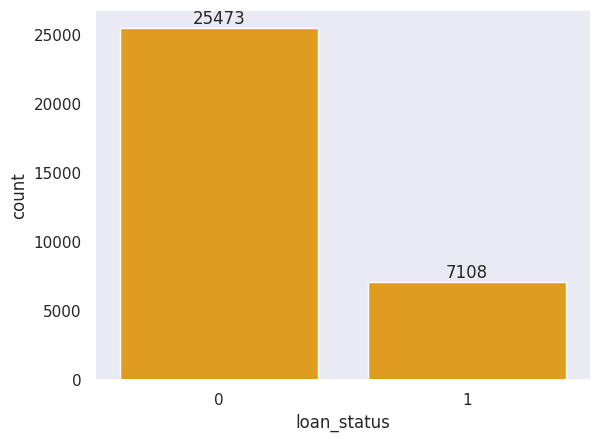

In [103]:
sns.set_theme(style='dark')
ax = sns.countplot(x=data.loan_status, color= 'orange')
ax.bar_label(ax.containers[0])

1. Count of 0 -> 25473, 1 -> 7108.
2. This implies that the dataset  is higly imbalnce ie. we do not have much observations for defaulters




# Data cleaning

Check for null values

loan_int_rate                 3116
person_emp_length              895
person_age                       0
person_income                    0
person_home_ownership            0
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

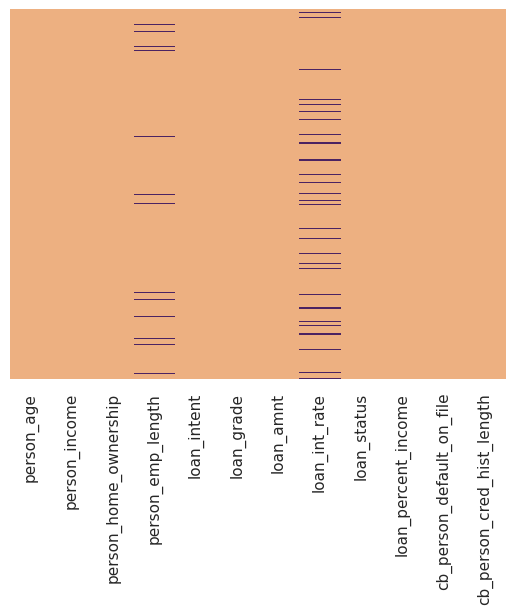

In [104]:
sns.heatmap(data.isnull(),cbar=False,yticklabels=False,cmap = 'flare')
data.isnull().sum().sort_values(ascending = False)

In [105]:
sorted(data['person_emp_length'].dropna().unique())

[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0,
 34.0,
 38.0,
 41.0,
 123.0]

In [106]:
#Checking the median and mode
print('Person emp length mode', data['person_emp_length'].mode()[0])
print('Person emp length median', data['person_emp_length'].median())
print('loan int rate mode', data['loan_int_rate'].mode()[0])
print('loan int rate median', data['loan_int_rate'].median())

Person emp length mode 0.0
Person emp length median 4.0
loan int rate mode 7.51
loan int rate median 10.99


In [107]:
#Filling the null values
data['person_emp_length'].fillna(data['person_emp_length'].mode()[0],inplace= True)
data['loan_int_rate'].fillna(data['loan_int_rate'].median(),inplace= True)

<Axes: >

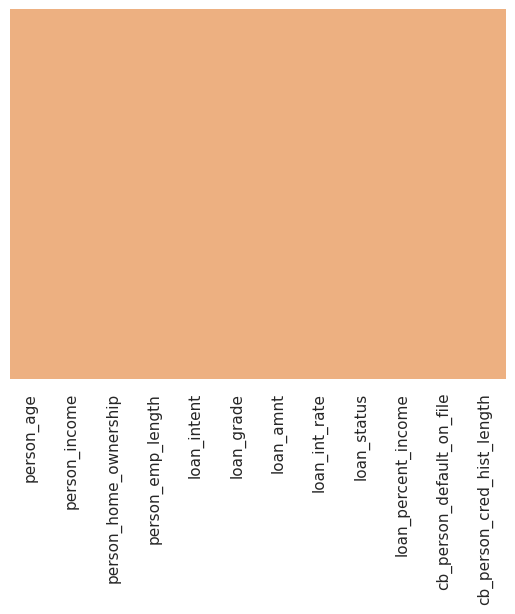

In [108]:
sns.heatmap(data.isnull(),cbar=False,yticklabels=False,cmap = 'flare')

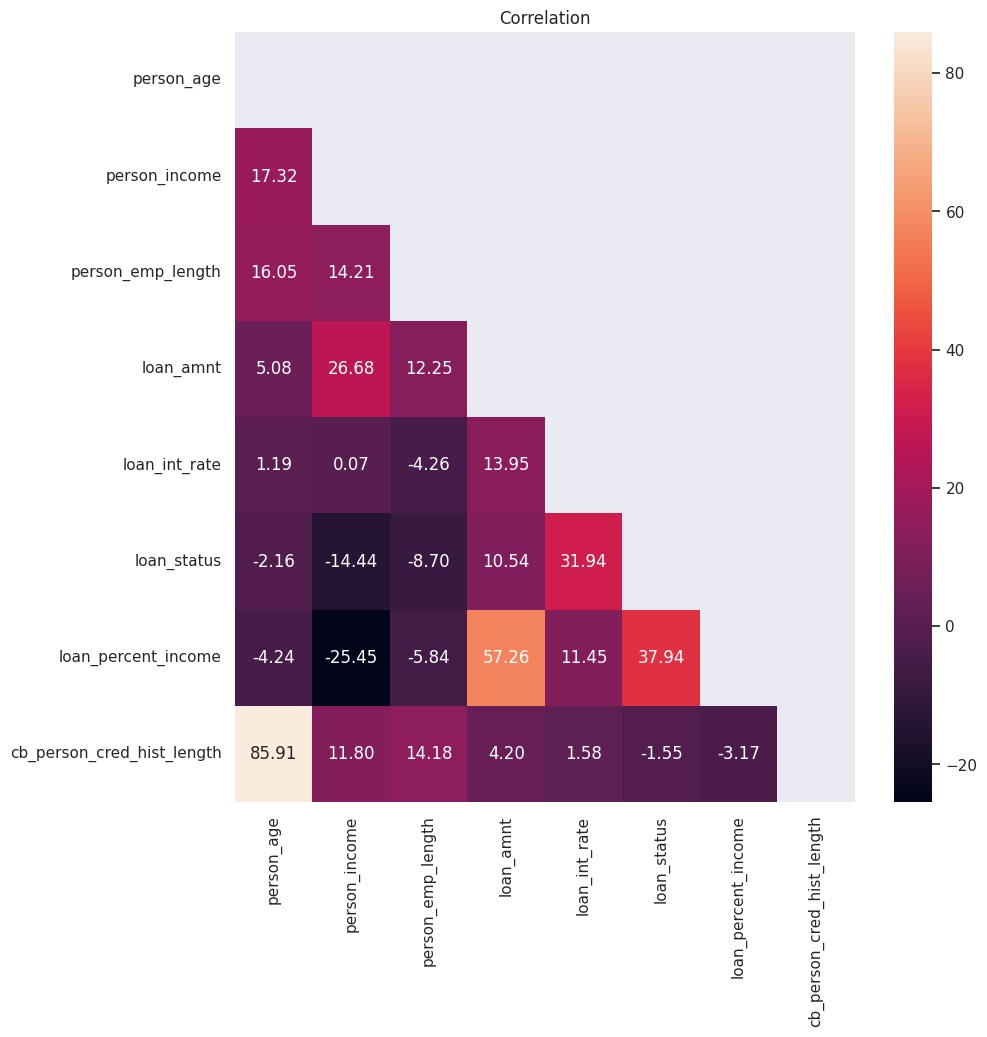

In [80]:
plt.figure(figsize=(10, 10))
data_num = data.select_dtypes(include=['number'])
corr = data_num.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr * 100, cmap = 'rocket', annot= True, fmt='.2f', mask=mask)
plt.title('Correlation')
plt.show()

In [109]:
#Listing the numerical featrues
num_cols =  pd.DataFrame(data[data.select_dtypes(include=['float','int']).columns])
num_cols.columns

Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_cred_hist_length'],
      dtype='object')

In [110]:
#Dropping the target variable
num_cols_x = num_cols.drop(['loan_status'], axis = 1)

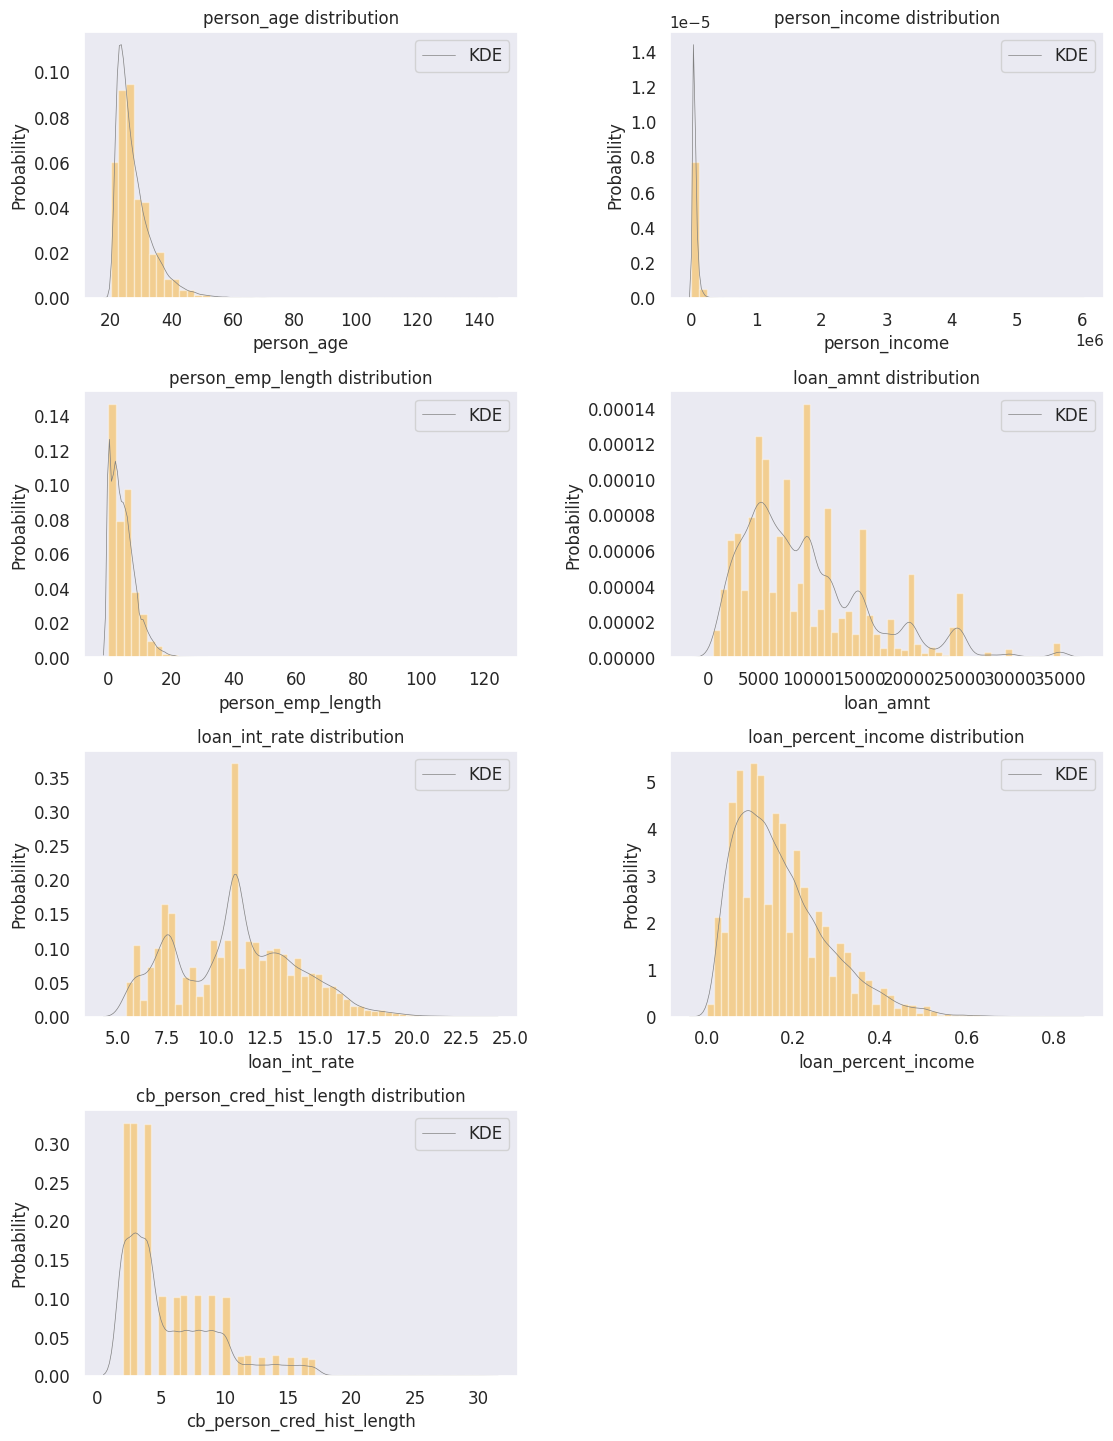

In [83]:
plt.figure(figsize=(12,16))

for i, col in enumerate(num_cols_x.columns):
  idx = int('42'+str(i+1))
  plt.subplot(idx)
  sns.distplot(num_cols_x[col], color = 'orange',kde_kws={'color':'gray','lw':0.5,'label':'KDE'})
  plt.title(col+' distribution',fontsize=12)
  plt.ylabel('Probability',fontsize=12)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  plt.xlabel(col,fontsize=12)
  plt.legend(['KDE'],prop={'size':12})
plt.subplots_adjust(top=0.92,bottom=0.08,left=0.10,right=0.95,hspace=0.35,wspace=0.35)
plt.show()



**Key  points:**
1. Most of the distributions are skewed.
2. person age : Distribution among age 20 to 60
3. Person emp length is between 0 to 30
4. person income : varies between 0 to 1 million

In [111]:
data

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


In [112]:
#removing outliers
data_n = data[data['person_age']<=100]
data_n = data_n[data_n['person_emp_length']<=60]
data_n = data_n[data_n['person_income']<=4e6]

In [113]:
data_n

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
5,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


In [26]:
data_num_cols = pd.DataFrame(data_n[data_n.select_dtypes(include=['float','int']).columns])

In [27]:
data_num_cols.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
1,21,9600,5.0,1000,11.14,0,0.10,2
2,25,9600,1.0,5500,12.87,1,0.57,3
3,23,65500,4.0,35000,15.23,1,0.53,2
4,24,54400,8.0,35000,14.27,1,0.55,4
5,21,9900,2.0,2500,7.14,1,0.25,2


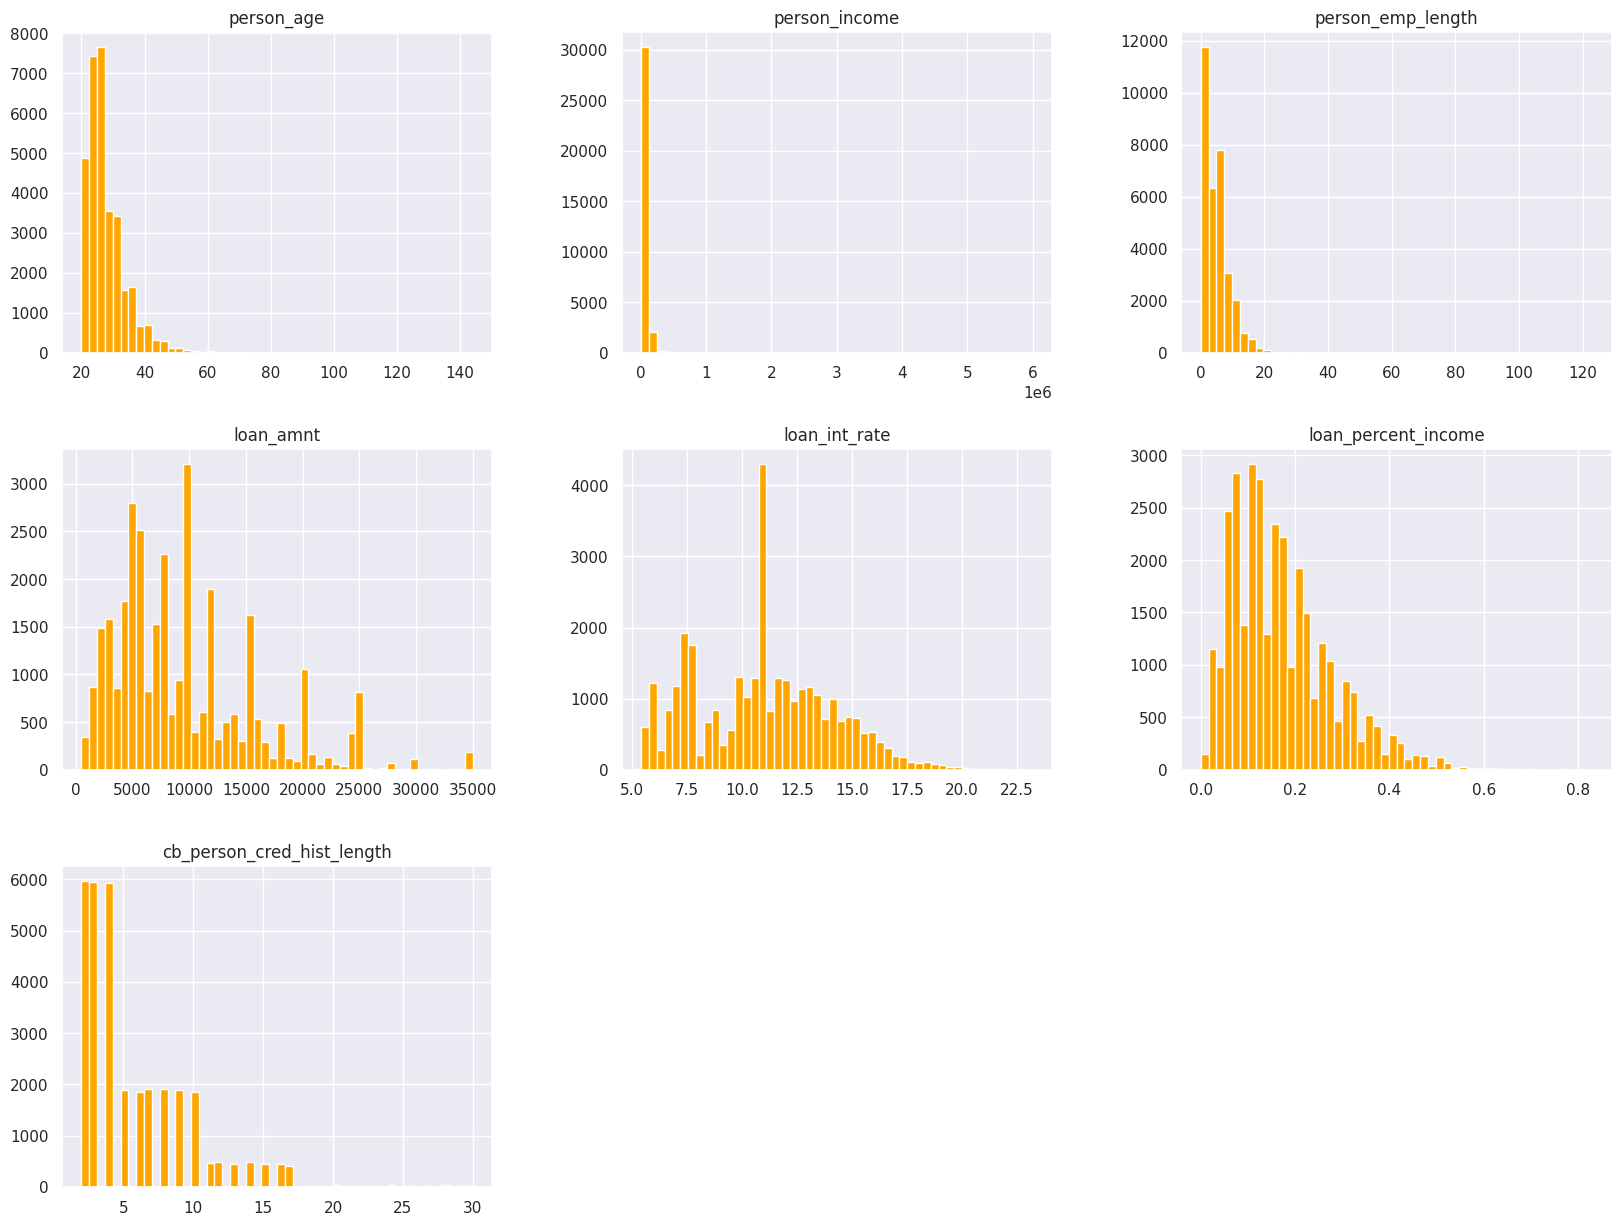

In [87]:
%matplotlib inline
import matplotlib.pyplot as plt
num_cols_x.hist(bins=50, figsize=(20,15),color='orange')
plt.show()


Text(0.5, 1.0, 'credit_num.corr()')

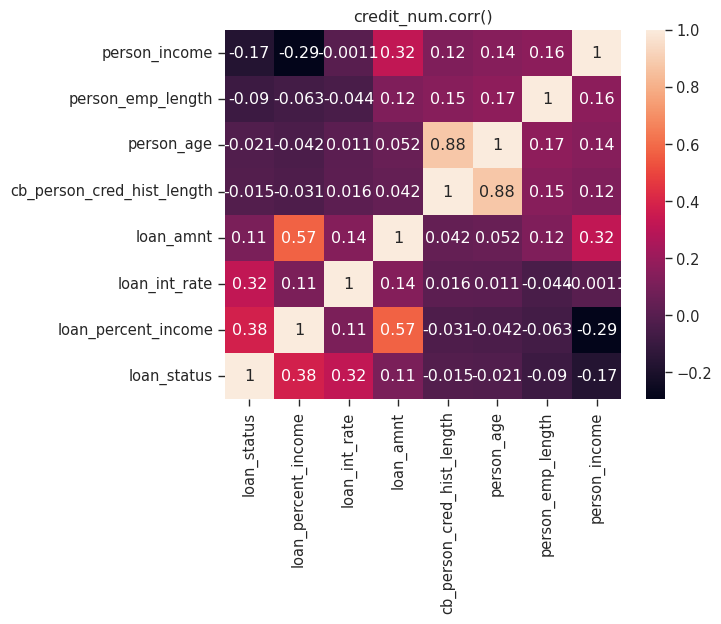

In [220]:
corr = data_num_cols.corr().sort_values('loan_status', axis = 1, ascending = False)
corr = corr.sort_values('loan_status', axis = 0, ascending=True)
sns.heatmap(corr,cmap='rocket',annot = True)
plt.title('credit_num.corr()')

In [30]:
#list out categorical features
cat_cols = pd.DataFrame(data_n[data_n.select_dtypes(include=['object']).columns])
cat_cols.columns

Index(['person_home_ownership', 'loan_intent', 'loan_grade',
       'cb_person_default_on_file'],
      dtype='object')

In [31]:
data_cat_col = pd.get_dummies(cat_cols, dtype =int)
cat_col_corr = pd.concat([data_cat_col, data_n['loan_status']],axis=1)

In [32]:
data_cat_col

,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
2,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
3,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
4,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
5,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32576,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0
32577,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0
32578,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0
32579,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0


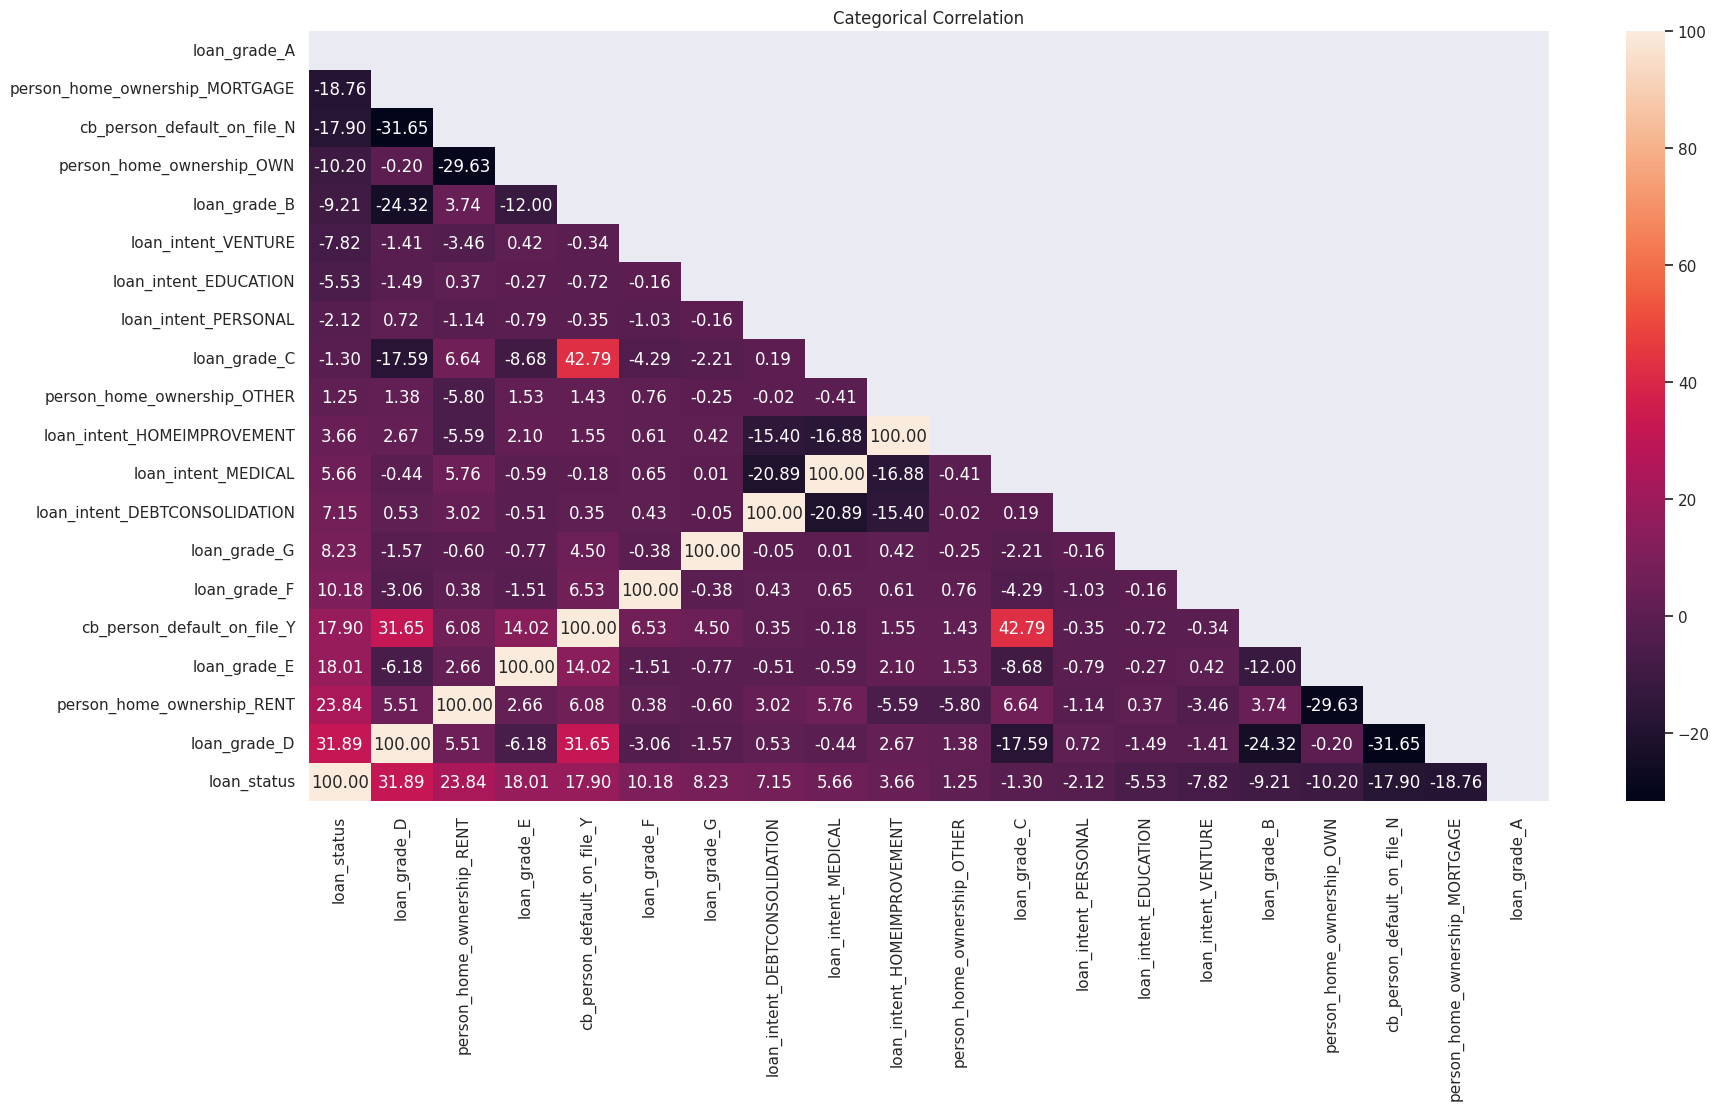

In [33]:
plt.figure(figsize=(20, 10))
# data_num = data.select_dtypes(include=['number'])
corr = cat_col_corr.corr().sort_values('loan_status', axis = 1, ascending = False)
corr = corr.sort_values('loan_status', axis = 0, ascending = True)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr * 100, cmap = 'rocket', annot= True, fmt='.2f', mask=mask)
plt.title('Categorical Correlation')
plt.show()

In [114]:
data_new = pd.concat([data_num_cols, data_cat_col], axis = 1)
data_new.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
1,21,9600,5.0,1000,11.14,0,0.10,2,0,0,...,0,0,1,0,0,0,0,0,1,0
2,25,9600,1.0,5500,12.87,1,0.57,3,1,0,...,0,0,0,1,0,0,0,0,1,0
3,23,65500,4.0,35000,15.23,1,0.53,2,0,0,...,0,0,0,1,0,0,0,0,1,0
4,24,54400,8.0,35000,14.27,1,0.55,4,0,0,...,0,0,0,1,0,0,0,0,0,1
5,21,9900,2.0,2500,7.14,1,0.25,2,0,0,...,1,1,0,0,0,0,0,0,1,0


In [115]:
data_new.shape

(32574, 27)

In [233]:
print(f'The cleaned dataset has {len(data_num_cols.columns)-1} and {len(data_cat_col.columns)} categorical features')

The cleaned dataset has 7 and 19 categorical features


# Model Building

In [118]:
target = data_new['loan_status']
features = data_new.drop('loan_status',axis = 1)
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=42, test_size=0.2)

X_train.shape, y_train.shape

((26059, 26), (26059,))

In [119]:
def model_asses(model, name = 'Default'):
  model.fit(X_train, y_train)
  preds = model.predict(X_test)
  preds_prob = model.predict_proba(X_test)
  print(name, '\n', classification_report(y_test,model.predict(X_test)))
  print('_'*60)

In [185]:
knn = KNeighborsClassifier(n_neighbors=150)
model_asses(knn, name = 'KNN')

log_reg = LogisticRegression(random_state = 42)
model_asses(log_reg, name ='Logistic Regression')

tree = DecisionTreeClassifier(max_depth =10, min_samples_split =2, min_samples_leaf = 1, random_state = 42)
model_asses(tree, 'Decision Tree Classifier')

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
model_asses(xgb_model, 'XGBoostClassifier')


KNN 
               precision    recall  f1-score   support

           0       0.85      0.96      0.90      5099
           1       0.74      0.40      0.52      1416

    accuracy                           0.84      6515
   macro avg       0.79      0.68      0.71      6515
weighted avg       0.83      0.84      0.82      6515

____________________________________________________________
Logistic Regression 
               precision    recall  f1-score   support

           0       0.81      0.99      0.89      5099
           1       0.75      0.16      0.26      1416

    accuracy                           0.81      6515
   macro avg       0.78      0.57      0.57      6515
weighted avg       0.80      0.81      0.75      6515

____________________________________________________________
Decision Tree Classifier 
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      5099
           1       0.95      0.72      0.82      1416

    a

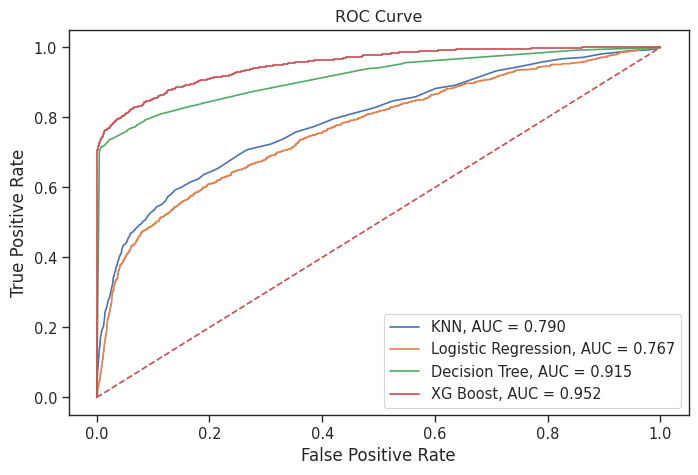

In [186]:
fig = plt.figure(figsize=(8,5))
plt.plot([0,1], [0,1], 'r--')

# Plotting ROC curves for each model
for name, model in [('KNN', knn), ('Logistic Regression', log_reg),
                    ('Decision Tree', tree), ('XG Boost', xgb_model)]:
    preds = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, preds)
    auc_score = roc_auc_score(y_test, preds)
    plt.plot(fpr, tpr, label=f'{name}, AUC = {auc_score:.3f}')

plt.ylabel('True Positive Rate', fontsize=12)
plt.xlabel('False Positive Rate', fontsize=12)
plt.title('ROC Curve')
plt.legend()
plt.show()


Feature Selection


In [187]:
feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance': xgb_model.feature_importances_})

new_features_df = feature_importance[feature_importance['importance']>0].sort_values(by=['importance'],ascending = False)

In [188]:
new_features_df

,feature,importance
10,person_home_ownership_RENT,0.192256
19,loan_grade_C,0.099848
5,loan_percent_income,0.098482
17,loan_grade_A,0.065224
11,loan_intent_DEBTCONSOLIDATION,0.057754
20,loan_grade_D,0.048055
9,person_home_ownership_OWN,0.047873
13,loan_intent_HOMEIMPROVEMENT,0.046148
14,loan_intent_MEDICAL,0.043346
4,loan_int_rate,0.041176


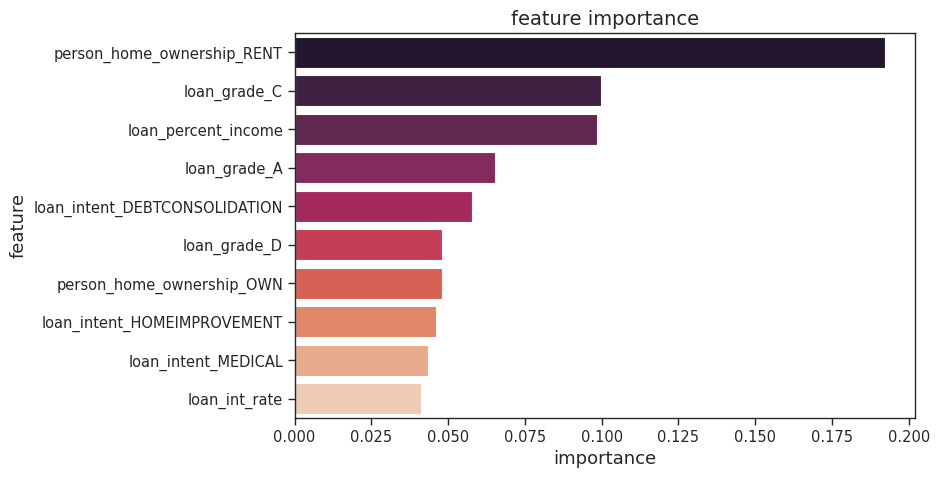

In [189]:
sns.set(context = 'paper', style='ticks', font='sans-serif', font_scale = 1.2, color_codes = True, rc = None)
figure, ax = plt.subplots(figsize=(8,5))
ax =  sns.barplot(data = new_features_df[:10], y = 'feature', x ='importance', palette='rocket')
ax.set_title('feature importance', fontsize=14)
ax.set_xlabel('importance', fontsize=13)
ax.set_ylabel('feature', fontsize=13)
plt.show()

hyperparameter tuning

In [190]:
#Random Search cv
params = {
    'colsample_bytre': uniform(0.9,0.1), #0.9 -> lower bound, 0.1 -> range
    'gamma': uniform(0.2,0.3),
    'learning_rate': uniform(0.2,0.2),
    'max_depth': randint(4,6),
    'n_estimators': randint(100,300),
    'subsample': uniform(0.9,0.1)
}
Random_cv = RandomizedSearchCV(xgb_model, param_distributions=params,random_state =42,
                               n_iter=100,cv=3, verbose=2, n_jobs=16, return_train_score=True)


Random_cv.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fb5e25ce9b0>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fb5da2ec3a0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fb5da2edb70>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fb5da2eeaa0>},
                   random_state=42, return_train_score=True, verbose=2)

In [221]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        top_indices = np.flatnonzero(results['rank_test_score'] == i)
        for idx in top_indices:
            print(f'Model with rank: {i}')
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                results['mean_test_score'][idx],
                results['std_test_score'][idx]))
            print("Parameters: {0}".format(results['params'][idx]))
            print('')


In [222]:
Random_best_xgb = Random_cv.best_estimator_
Random_best_xgb.fit(X_train, np.ravel(y_train))
preds_proba_Random = Random_best_xgb.predict_proba(X_test)
probs_Random = preds_proba_Random[:, 1]
Random_bestauc = roc_auc_score(y_test, probs_Random)
print (f'xgb base model AUROC socre: {aucxgb}')
print (f'xgb best model using RandomizedSearchCV AUROC socre: {Random_bestauc}')

xgb base model AUROC socre: 0.9517606476510848
xgb best model using RandomizedSearchCV AUROC socre: 0.9512154399389268


In [223]:
params = {
    'colsample_bytree': [0.91,0.96],
    'gamma':[0.41],
    'learning_rate': [0.21],
    'max_depth': [5],
    'n_estimators': [192, 263, 113],
    'subsample':[0.98, 0.96, 0.97]
}
Grid_CV = GridSearchCV(xgb_model, param_grid=params, cv=3, verbose=1, n_jobs=16, return_train_score=True)
Grid_CV.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=16,
             param_grid={'colsample_bytree': [0.91, 0.96], 'gamma': [0.41],
                         'learning_rate': [0.21], 'max_depth': [5],
                         'n_estimators': [192, 263, 113],
                         'subsample': [0.98, 0.96, 0.97]},
             return_train_score=True, verbose=1)

In [193]:
report_best_scores(Grid_CV.cv_results_, 3)

Model with rank: 1
Mean validation score: 0.935 (std: 0.002)
Parameters: {'colsample_bytree': 0.96, 'gamma': 0.41, 'learning_rate': 0.21, 'max_depth': 5, 'n_estimtors': 192, 'subsample': 0.97}

Model with rank: 1
Mean validation score: 0.935 (std: 0.002)
Parameters: {'colsample_bytree': 0.96, 'gamma': 0.41, 'learning_rate': 0.21, 'max_depth': 5, 'n_estimtors': 263, 'subsample': 0.97}

Model with rank: 1
Mean validation score: 0.935 (std: 0.002)
Parameters: {'colsample_bytree': 0.96, 'gamma': 0.41, 'learning_rate': 0.21, 'max_depth': 5, 'n_estimtors': 113, 'subsample': 0.97}

Model with rank: 2
Mean validation score: 0.935 (std: 0.002)
Parameters: {'colsample_bytree': 0.96, 'gamma': 0.41, 'learning_rate': 0.21, 'max_depth': 5, 'n_estimtors': 192, 'subsample': 0.97}

Model with rank: 2
Mean validation score: 0.935 (std: 0.002)
Parameters: {'colsample_bytree': 0.96, 'gamma': 0.41, 'learning_rate': 0.21, 'max_depth': 5, 'n_estimtors': 263, 'subsample': 0.97}

Model with rank: 2
Mean valida

In [202]:
grid_best_xgb  = Grid_CV.best_estimator_
grid_best_xgb.fit(X_train, np.ravel(y_train))
preds_proba_grid = grid_best_xgb.predict_proba(X_test)
probs_grid = preds_proba_grid[:,1]
Grid_bestauc = roc_auc_score(y_test, probs_grid)
print (f'xgb base model AUROC socre: {aucxgb}')
print (f'xgb best model using RandomizedSearchCV AUROC socre: {Random_bestauc}')
print (f'xgb best model using GridSearchCV AUROC socre: {Grid_bestauc}')

xgb base model AUROC socre: 0.9517606476510848
xgb best model using RandomizedSearchCV AUROC socre: 0.9513681368785062
xgb best model using GridSearchCV AUROC socre: 0.949199563335228


In [203]:
pred_xgb

array([[9.5095187e-01, 4.9048111e-02],
       [9.6956664e-01, 3.0433344e-02],
       [9.9979240e-01, 2.0762657e-04],
       ...,
       [5.3865016e-02, 9.4613498e-01],
       [9.9547446e-01, 4.5255329e-03],
       [9.6452183e-01, 3.5478149e-02]], dtype=float32)

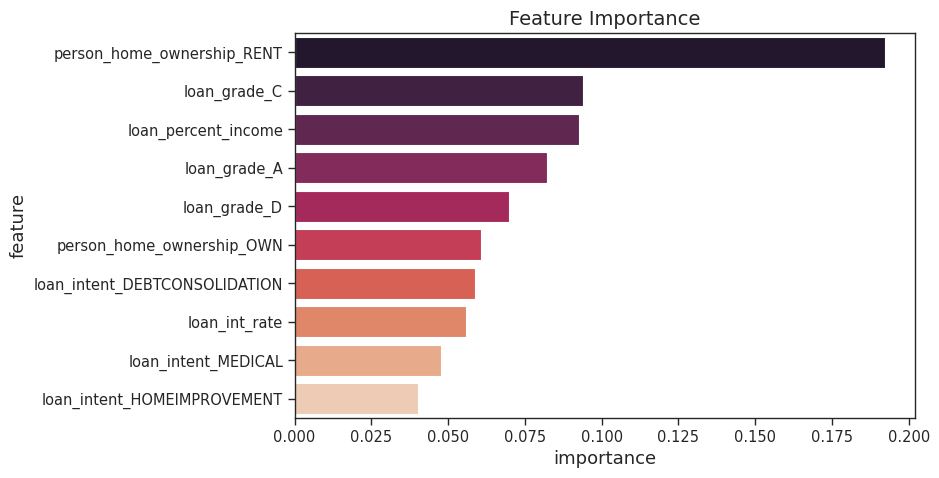

In [204]:
#Plot Feature importance
feature_importance = pd.DataFrame({'feature': X_train.columns,
                                   'importance': grid_best_xgb.feature_importances_})

new_features_df = feature_importance[feature_importance['importance']>0
                                    ].sort_values(by=['importance'],ascending=False)

sns.set(context='paper', style='ticks',  font='sans-serif',
        font_scale=1.2, color_codes=True, rc=None)
figure, ax = plt.subplots(figsize=(8, 5))
ax=sns.barplot(data = new_features_df[:10],
              y='feature',
              x='importance',
              palette='rocket') # rocket, Blues_d
ax.set_title('Feature Importance', fontsize=14)
ax.set_xlabel('importance', fontsize=13)
ax.set_ylabel('feature', fontsize=13)
plt.show()

In [205]:
# list out the top 10 important features
new_features_df.head(10)

,feature,importance
1,person_home_ownership_RENT,0.192290
9,loan_grade_C,0.094009
2,loan_percent_income,0.092714
3,loan_grade_A,0.082145
0,loan_grade_D,0.069679
7,person_home_ownership_OWN,0.060638
5,loan_intent_DEBTCONSOLIDATION,0.058872
13,loan_int_rate,0.055859
8,loan_intent_MEDICAL,0.047635
10,loan_intent_HOMEIMPROVEMENT,0.040056


In [206]:
# Extracting the top 20 feature names
top_20_features = new_features_df['feature'].iloc[:20]

# Converting to a list
top_20_features_list = top_20_features.tolist()

# Displaying the selected top 20 features
print(top_20_features_list)

# Create a new DataFrame containing only the top 20 features
new_features_df = data_new[top_20_features_list]

# Display the shape of the new DataFrame
print("Shape of the new DataFrame:", new_features_df.shape)

# Split the dataset into training and testing sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(new_features_df, target, random_state=42, test_size=0.2)

# Display the shapes of the training and testing sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

['person_home_ownership_RENT', 'loan_grade_C', 'loan_percent_income', 'loan_grade_A', 'loan_grade_D', 'person_home_ownership_OWN', 'loan_intent_DEBTCONSOLIDATION', 'loan_int_rate', 'loan_intent_MEDICAL', 'loan_intent_HOMEIMPROVEMENT', 'person_income', 'loan_grade_B', 'loan_intent_VENTURE', 'loan_grade_E', 'loan_grade_G', 'person_home_ownership_MORTGAGE', 'loan_grade_F', 'person_emp_length', 'person_home_ownership_OTHER', 'loan_intent_EDUCATION']
Shape of the new DataFrame: (32574, 20)
Shape of X_train: (26059, 20)
Shape of X_test: (6515, 20)
Shape of y_train: (26059,)
Shape of y_test: (6515,)


In [224]:
params = {
    'colsample_bytree': uniform(0.9,0.1),
    'gamma': uniform(0.2,0.3),
    'learning_rate': uniform(0.2,0.3),
    'max_depth': randint(4,6),
    'n_estimators' : randint(100,300),
    'subsample': uniform(0.9,0.1)
}
Random_CV = RandomizedSearchCV(xgb_model, param_distributions= params, random_state=42, n_iter=100, cv=3, verbose=2, n_jobs=16,return_train_score=True)
Random_CV.fit(X_train1, y_train1)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fb5e23159f0>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fb5da665f60>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fb5da667970>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fb5da666620>},
                   random_state=42, return_train_score=True, verbose=2)

In [225]:
report_best_scores(Random_CV.cv_results_, 3)

Model with rank: 1
Mean validation score: 0.933 (std: 0.001)
Parameters: {'colsample_bytree': 0.9974248208534411, 'gamma': 0.4987793726090987, 'learning_rate': 0.21676134640320502, 'max_depth': 4, 'n_estimators': 174, 'subsample': 0.9117067016427606}

Model with rank: 2
Mean validation score: 0.933 (std: 0.002)
Parameters: {'colsample_bytree': 0.9094442960755929, 'gamma': 0.40490203202490704, 'learning_rate': 0.22135659453806872, 'max_depth': 5, 'n_estimators': 192, 'subsample': 0.9844875310969454}

Model with rank: 3
Mean validation score: 0.933 (std: 0.001)
Parameters: {'colsample_bytree': 0.9142991682052836, 'gamma': 0.4284531895152417, 'learning_rate': 0.3854654189948783, 'max_depth': 4, 'n_estimators': 106, 'subsample': 0.9426091475046942}



In [211]:
random_best_xgb = Random_CV.best_estimator_
random_best_xgb.fit(X_train1, np.ravel(y_train1))
preds_proba_Random = random_best_xgb.predict_proba(X_test1)
probs_random = preds_proba_Random[:,1]
Random_bestauc = roc_auc_score(y_test1, probs_Random)
print(f'xgb base model AUCROC score {aucxgb}')
print(f'xgb best model using Random search cv auc score: {Random_bestauc}')

xgb base model AUCROC score 0.9517606476510848
xgb best model using Random search cv auc score: 0.9513681368785062


In [226]:
preds = grid_best_xgb.predict_proba(X_test)
pred_probs = pd.DataFrame(preds[:,1],columns = ['Default Probability'])

pd.concat([pred_probs, y_test.reset_index(drop=True)],axis=1)
thresh = np.linspace(0,1,41)
thresh

array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
       0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
       0.45 , 0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 ,
       0.675, 0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875,
       0.9  , 0.925, 0.95 , 0.975, 1.   ])

In [229]:
def optimize_threshold(predictions_df, thresholds, true_labels):
    """
    Optimize the threshold for classifying predictions.

    Args:
    - predictions_df (pd.DataFrame): DataFrame containing the predicted probabilities.
    - thresholds (list): List of threshold values to evaluate.
    - true_labels (pd.Series): Series containing the true labels.

    Returns:
    - accs (list): List of accuracy scores for each threshold.
    - def_recalls (list): List of recall scores for default cases for each threshold.
    - nondef_recalls (list): List of recall scores for non-default cases for each threshold.
    """
    accs = []
    def_recalls = []
    nondef_recalls = []

    for threshold in thresholds:
        # Apply the threshold to classify the predictions
        predictions_df['loan_status'] = (predictions_df['Default Probability'] > threshold).astype(int)

        # Calculate accuracy and recall scores
        accuracy = accuracy_score(true_labels, predictions_df['loan_status'])
        recall_def = recall_score(true_labels, predictions_df['loan_status'], pos_label=1)
        recall_nondef = recall_score(true_labels, predictions_df['loan_status'], pos_label=0)

        # Append scores to lists
        accs.append(accuracy)
        def_recalls.append(recall_def)
        nondef_recalls.append(recall_nondef)

    return accs, def_recalls, nondef_recalls

# Call the function with appropriate arguments
accs, def_recalls, nondef_recalls = optimize_threshold(pred_probs, thresholds=thresh, true_labels=y_test)


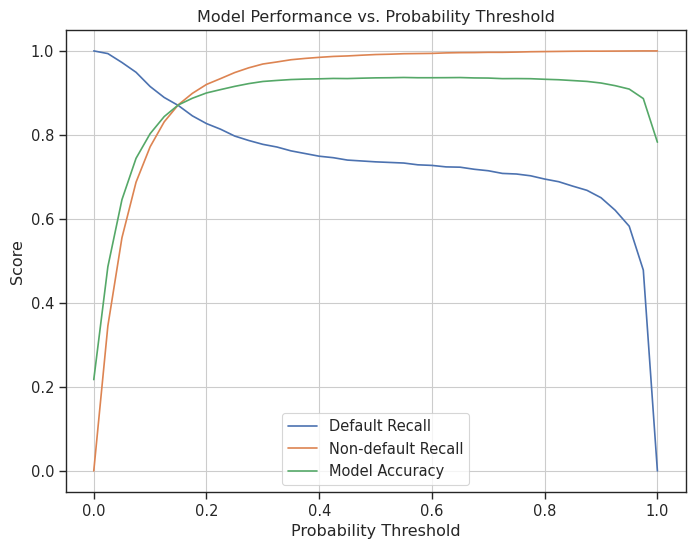

In [232]:
plt.figure(figsize=(8, 6))
plt.plot(thresh, def_recalls, label='Default Recall')
plt.plot(thresh, nondef_recalls, label='Non-default Recall')
plt.plot(thresh, accs, label='Model Accuracy')

# Adding labels and legend
plt.xlabel("Probability Threshold")
plt.ylabel("Score")
plt.title("Model Performance vs. Probability Threshold")
plt.legend()

# Show plot
plt.grid(True)
plt.show()

In [231]:
optim_threshold = accs.index(max(accs))

print(f'The model accuracy is {accs[optim_threshold]} using the optimal probabilty threshold'
     )

print (f'The optimal probabilty threshold is {thresh[optim_threshold]}')

The model accuracy is 0.9367613200306983 using the optimal probabilty threshold
The optimal probabilty threshold is 0.55


XGBClassifier outperforms other models, with 0.957 AUROC score compared to 'KNN', 'Logistic_Regression' and 'Decision Tree'.

The optimal probability threshold is 0.5, with accuracy of 0.937.